## **IMPORT DATASET**

In [21]:
import pandas as pd
import missingno as msno

url = "https://raw.githubusercontent.com/WiraDKP/supervised_learning/refs/heads/master/08%20-%20Regression%20Evaluation/data/taxi_fare.csv"
data = pd.read_csv(url, parse_dates=["pickup_datetime"])

data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


## **MISSING VALUES**

<Axes: >

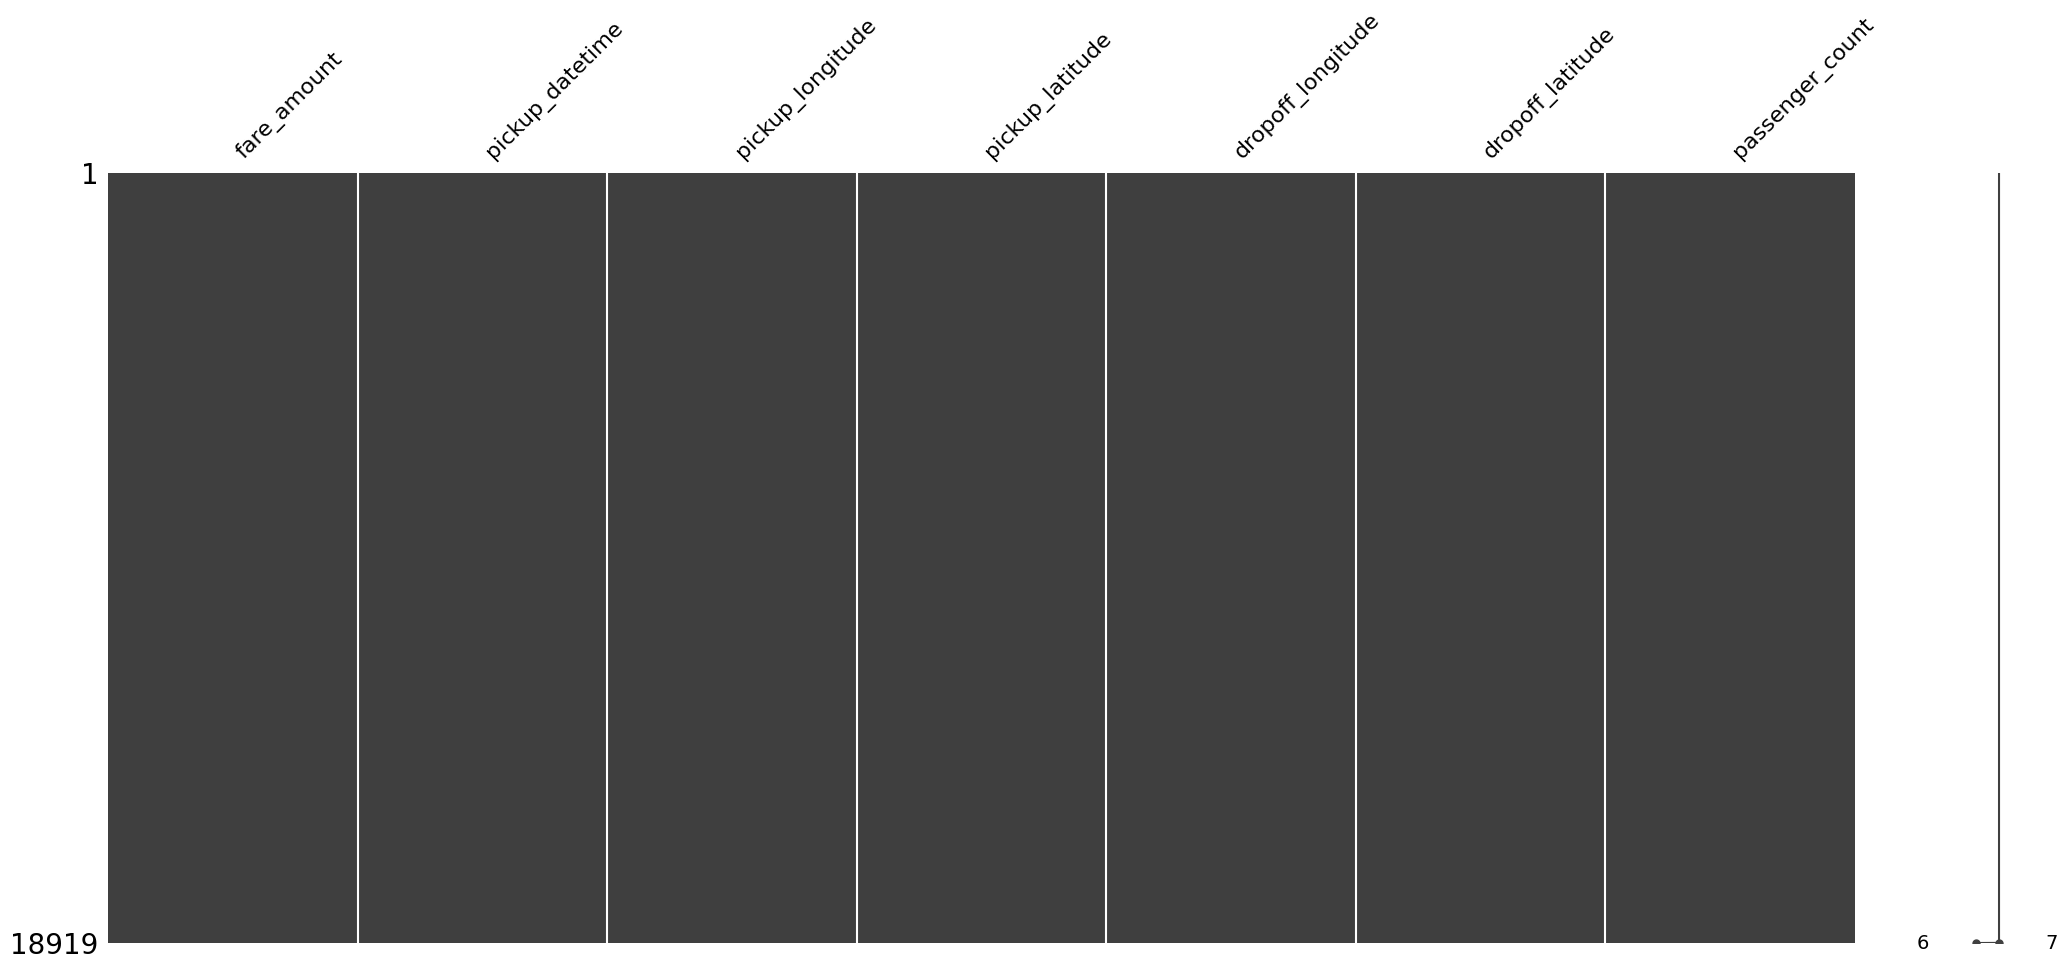

In [2]:
msno.matrix(data)

In [3]:
missing_columns = data.isnull().sum()
print("Jumlah missing di setiap kolom:")
print(missing_columns)

Jumlah missing di setiap kolom:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64


In [4]:
data.dropna(inplace=True)

In [5]:
missing_columns = data.isnull().sum()
print("Jumlah missing di setiap kolom:")
print(missing_columns)

Jumlah missing di setiap kolom:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## **Extract Time Feature**

In [6]:
pickup_dt = data["pickup_datetime"].dt

data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.dayofweek
data['hour'] = pickup_dt.hour
data.drop(columns='pickup_datetime', inplace=True)
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


## **Extract Distance**

In [7]:
data['distance'] = abs(data['pickup_longitude'] - data['dropoff_longitude']) + abs(data['pickup_latitude'] - data['dropoff_latitude'])
data.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
data.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


## **SPLITTING**

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="fare_amount")
y = data["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [12]:
X_train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'distance'], dtype='object')

## **Pipeline Machine Learning: Polynomial Regression + Yeo-Johnson + Hyperparameter Tuning**

In [9]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'))  # Transformasi Yeo-Johnson
        ]), ['passenger_count', 'year', 'distance']),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ['month', 'day', 'hour'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),  # Polynomial Features
    ('algo', LinearRegression())  # Model Linear Regression
])

parameter = {
    'algo__fit_intercept': [True, False],
    'poly__degree': [2, 3],
    'poly__interaction_only': [True, False]  # Hanya interaksi antar fitur tanpa suku pangkat
}

In [10]:
model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('yeo_johnson',
                                                                                          PowerTransformer())]),
                                                                         ['passenger_count',
                                                                          'year',
                                                                          'distance']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day',
                                                                          'hour'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('algo', LinearRegression())]),
             n_jobs=-1,
             param_grid={'algo__fit_intercept': [True, False],
                         'poly__degree': [2, 3],
                         'poly__interaction_only': [True, False]},
             verbose=1)

## **EVALUASI MODEL**

In [11]:
print(f"Best parameters: {model.best_params_}")
print(f"Training R²: {model.score(X_train, y_train)}")
print(f"Validation R²: {model.best_score_}")
print(f"Test R²: {model.score(X_test, y_test)}")

Best parameters: {'algo__fit_intercept': False, 'poly__degree': 2, 'poly__interaction_only': False}
Training R²: 0.6814399420832529
Validation R²: 0.6418127048648947
Test R²: 0.6745012330874967


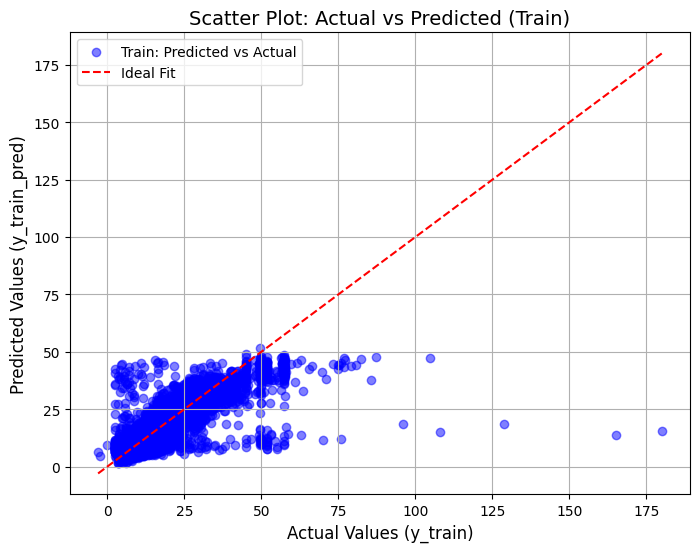

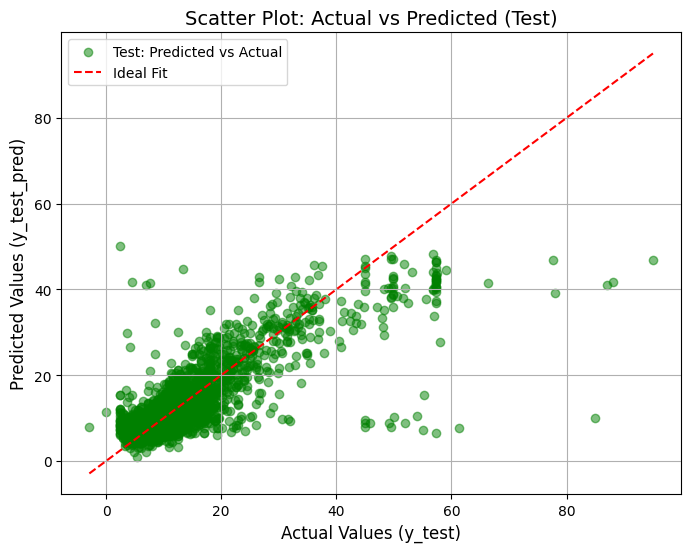

In [25]:
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Train: Predicted vs Actual')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Actual vs Predicted (Train)', fontsize=14)
plt.xlabel('Actual Values (y_train)', fontsize=12)
plt.ylabel('Predicted Values (y_train_pred)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='green', alpha=0.5, label='Test: Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Actual vs Predicted (Test)', fontsize=14)
plt.xlabel('Actual Values (y_test)', fontsize=12)
plt.ylabel('Predicted Values (y_test_pred)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

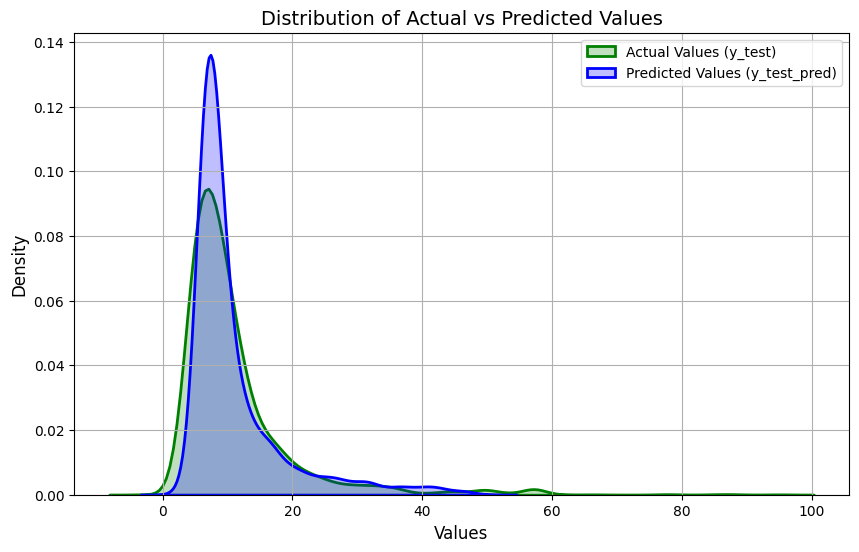

In [28]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, color='green', label='Actual Values (y_test)', fill=True, linewidth=2)
sns.kdeplot(y_test_pred, color='blue', label='Predicted Values (y_test_pred)', fill=True, linewidth=2)

plt.title('Distribution of Actual vs Predicted Values', fontsize=14)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

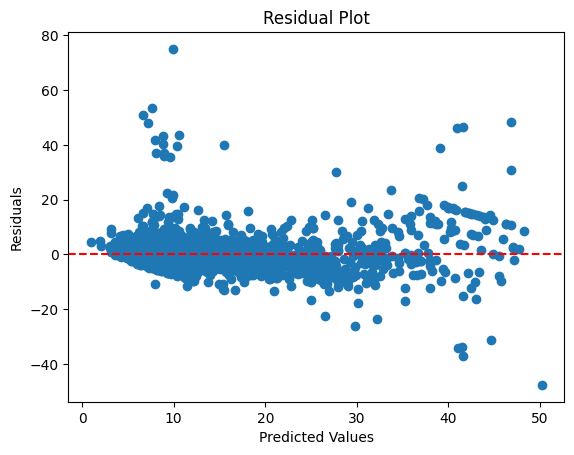

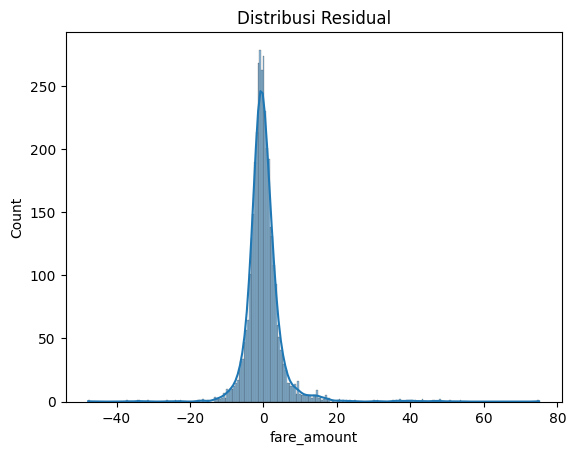

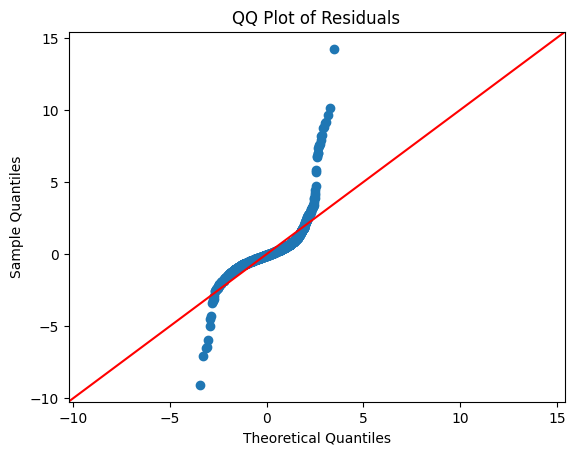

In [29]:
import statsmodels.api as sm

residuals = y_test - y_test_pred

plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Distribusi Residual")
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

## **SAVE MODEL**

In [13]:
import pickle

with open('taxifare.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan")

Model berhasil disimpan


## **LOAD MODEL DAN PREDICT**

In [15]:
with open('taxifare.pkl', 'rb') as file:
    model = pickle.load(file)

print("Model berhasil dimuat")

Model berhasil dimuat


In [23]:
X_train.iloc[1]

,578
passenger_count,3.000000
year,2010.000000
month,3.000000
day,3.000000
hour,10.000000
distance,0.009293


In [19]:
data_baru = pd.DataFrame([{
    'passenger_count': 2.0,
    'year': 2015.0,
    'month': 12.0,
    'day': 25.0,
    'hour': 18.0,
    'distance': 5.3
}])

prediksi = model.predict(data_baru)
print(f"Prediksi Fare Amount: {prediksi[0]}")

Prediksi Fare Amount: 44.480073346547684
